# Assignment 5 – Speech recognition
**`HMMs` | `Markov Models` | `Bayes Rule`**

---

## 1. Language Detection
There are three languages: A, B and C. Each language uses the same set of symbols: "A, o, e, t, p, g, and k." However, each language uses the symbols differently. In each of these languages we can model everything as P(next symbol | current symbol).

1. There is training data available for each language. This consists of several files each generated by sampling from a Markov model. Using Python, build a Markov model for each of the languages.
2. Now use the Markov model and Bayes' rule to classify the test cases. Write down how you used Bayes' rule to get your classifier. Give the full posterior distribution for each test case.

### a. Import packages/libraries

In [1]:
from glob import glob
import pandas as pd

### b. Build a Markov model for each language

####  (i) Find the initial distribution for each language
*With what probability does each letter occur first?*

In [2]:
def generate_init_distribution(lang):
    
    """
    Function to determine the probability of the different letters starting 
    a sequence in a given language
    
    Input(s):
        - lang (str): The language in focus
    
    Output(s):
        - starting_letters (dict): Dictionary indicating the probabilities of each 
                                   letter starting a sequence in lang
    
    """
    
    #Dictionary to store the first letter across all training samples
    #Initialize with 0 for each letter
    starting_letters = {'A':0, 'o':0, 'e':0, 't':0, 'p':0, 'g':0, 'k':0}
    
    #Get all the files for the particular language
    for path in glob(f'symbol/language-training-lang{lang}-?'):
        
        #Open each file
        file = open(path, "r").read()
        
        #Note the letter that started the training sample
        starting_letters[file[0]] += 1
    
    #Determine the probability each letter begins first
    total = sum(starting_letters.values(), 0.0)
    
    for letter in starting_letters:
        starting_letters[letter] /= total
    
    return starting_letters

#Example: Probabilities of the different letters starting in language A
generate_init_distribution('A')

{'A': 0.1, 'o': 0.1, 'e': 0.0, 't': 0.3, 'p': 0.2, 'g': 0.1, 'k': 0.2}

####  (ii) Find the transition matrix for each language

In [3]:
def determine_transition_matrix(lang):
    
    """
    Function to determine the transition matrix for a language lang
    
    Input(s):
        - lang (str): The language in focus
    
    Output(s):
        - transition_matrix (dict): Dictionary indicating the probabilities of transitioning from 
                                    each letter to every other letter in a given language
     
    Note: We consider transitions across all the different training samples for a given language
    
    """
    
    #Note down all the possible letters
    alphabet = ['A', 'o', 'e', 't', 'p', 'g', 'k']
    
    #List to store each training samples sequence
    sequence_list = []
    
    #Get all the files for the particular language
    for path in glob(f'symbol/language-training-lang{lang}-?'):
        
        #Open each file
        file = open(path, "r").read()
        
        #Add each files sequence to the language's global sequence lsit
        sequence_list.append(file)
        
    
    #The global transition matrix
    transition_matrix = {
      
        "A": {'A':0, 'o':0, 'e':0, 't':0, 'p':0, 'g':0, 'k':0},
        "o": {'A':0, 'o':0, 'e':0, 't':0, 'p':0, 'g':0, 'k':0},
        "e": {'A':0, 'o':0, 'e':0, 't':0, 'p':0, 'g':0, 'k':0},
        "t": {'A':0, 'o':0, 'e':0, 't':0, 'p':0, 'g':0, 'k':0},
        "p": {'A':0, 'o':0, 'e':0, 't':0, 'p':0, 'g':0, 'k':0},
        "g": {'A':0, 'o':0, 'e':0, 't':0, 'p':0, 'g':0, 'k':0},
        "k": {'A':0, 'o':0, 'e':0, 't':0, 'p':0, 'g':0, 'k':0},
        
    }
    
    #Iterate through all the training samples
    for file in sequence_list:
        
        #Dictionary to store the subject of the transition and the transition
        for curr_letter in range(len(file)-1):
            
            #Get the current alphabet and note the next alphabet
            transition_matrix[file[curr_letter]][file[curr_letter+1]] += 1
        
    #Convert counts to probabilities
    for transition_subject in transition_matrix:
        
        total = sum(transition_matrix[transition_subject].values(), 0.0)
        
        for letter in transition_matrix[transition_subject]:
            transition_matrix[transition_subject][letter] /= total
    
    return transition_matrix
        
    
#Example:
mat = determine_transition_matrix('B')
mat_df = pd.DataFrame(mat)
mat_df['row_sum'] = mat_df.sum(axis=0) #Ensure it's a valid probability distribution
mat_df

,A,o,e,t,p,g,k,row_sum
A,0.022422,0.395604,0.016949,0.413174,0.000000,0.477124,0.000000,1.0
o,0.300448,0.071429,0.317797,0.041916,0.357143,0.058824,0.400000,1.0
e,0.031390,0.423077,0.033898,0.491018,0.071429,0.385621,0.066667,1.0
t,0.300448,0.054945,0.305085,0.017964,0.214286,0.065359,0.200000,1.0
p,0.040359,0.000000,0.012712,0.000000,0.071429,0.000000,0.000000,1.0
g,0.273543,0.054945,0.279661,0.035928,0.285714,0.013072,0.333333,1.0
k,0.031390,0.000000,0.033898,0.000000,0.000000,0.000000,0.000000,1.0


### c. Use the Markov model and Bayes’ rule to classify the test cases

#### Bayes rule
- p(language | string) = $\frac{p(string| language) \times p(language)}{p(string)}$

- posterior = p(language | string)
- likelihood = p(string = | language)

Here a uniform prior is assumed, so I don't include the priors in the calculation – it has no effect. As a result, the denominator (i.e. the normalization constant) is simply a sum of the likelihoods as we see below:

In [4]:
def classify_test_cases():
    
    """
    Function to classify test cases into the most-likely language that generated them
    """
    
    #Iterate through all the test cases
    for idx, path in enumerate(glob(f'symbol/language-test-?')):

        #List to track the likelihood
        likelihoods = {'A':1,'B':1,'C':1}

        #Open each test case
        file = open(path, "r").read()

        #Get the initial state (i.e. starting letter)
        test_init_state = file[0]
        
        #Determine the likelihood for each language
        #p(test_string| language)
        for lang in ['A','B','C']:

            #Determine probability that the language generated the first letter of the test sample
            #P(next symbol | ∅ ) 
            init_distribution = generate_init_distribution(lang)
            prob_first_letter = init_distribution[test_init_state]

            #Append this probability to the likelihood (for the language)
            likelihoods[lang] *= prob_first_letter

            #Compute the language transition matrix
            lang_trans_mat = determine_transition_matrix(lang)

            #Iterate through the test sequence and find P(next symbol|previous symbol)
            for symbol in range(len(file)-1):

                likelihoods[lang] *= lang_trans_mat[file[symbol]][file[symbol+1]]
                
        
        #Normalize the likelihood to get posterior
        posterior = likelihoods.copy()
        
        total = sum(posterior.values(), 0.0)
        for key in posterior:
            posterior[key] /= total
            #posterior[key] = round(posterior[key],3)
            
        print(f"Sequence: {file}")
        print('------------------------')
        plt.figure(figsize=(3,2), dpi=200)
        plt.bar(*zip(*posterior.items()))
        plt.gcf().text(1, 0.6, f'Posterior Distribution:{posterior}')
        plt.gcf().text(1, 0.4, f'Classification: Language {max(posterior, key=posterior.get)}')
        plt.show()
            

Sequence: AtAgegegegAgegetoAtetAogAooAoeAtegAgeotAoAgoetAteAteoegoeogetekoAoegAoegAtegAgeotAtAoAtetAtgeggAtAto
------------------------


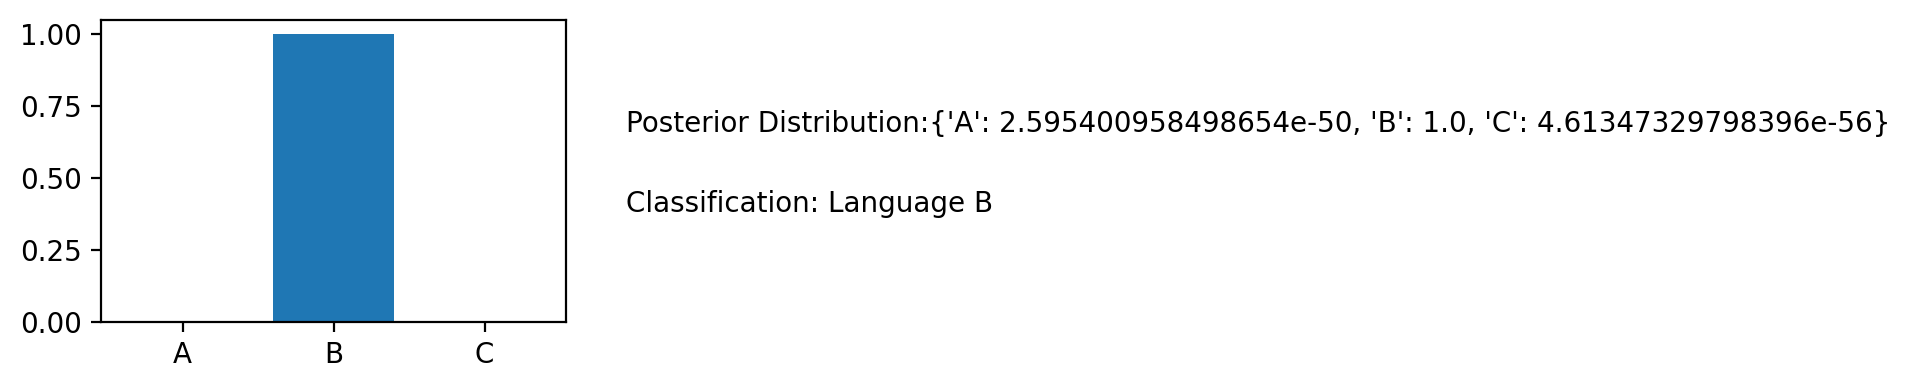

Sequence: popoktgopogettpegAtkegotkogettpApepApegtgApeogokokApetkAgegokpepketpotttpAtkopepototpApettgotokotgok
------------------------


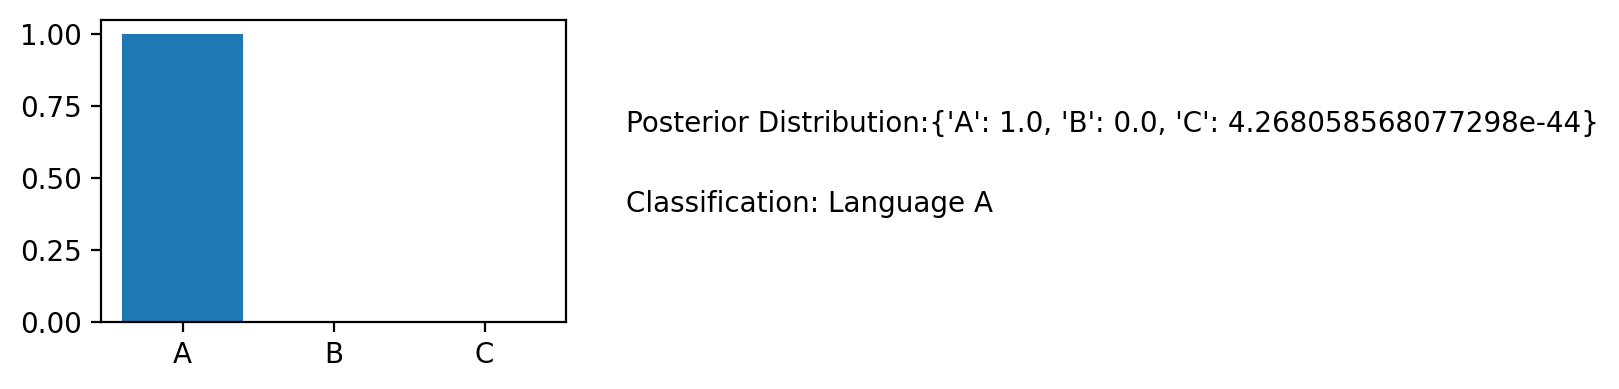

Sequence: okopottogttpetgopopotkepeppAgAgetpotpAtgookettgoketkokAgAttpgopAgtkAggAgekottgokAkopApAkopAtgtttpokp
------------------------


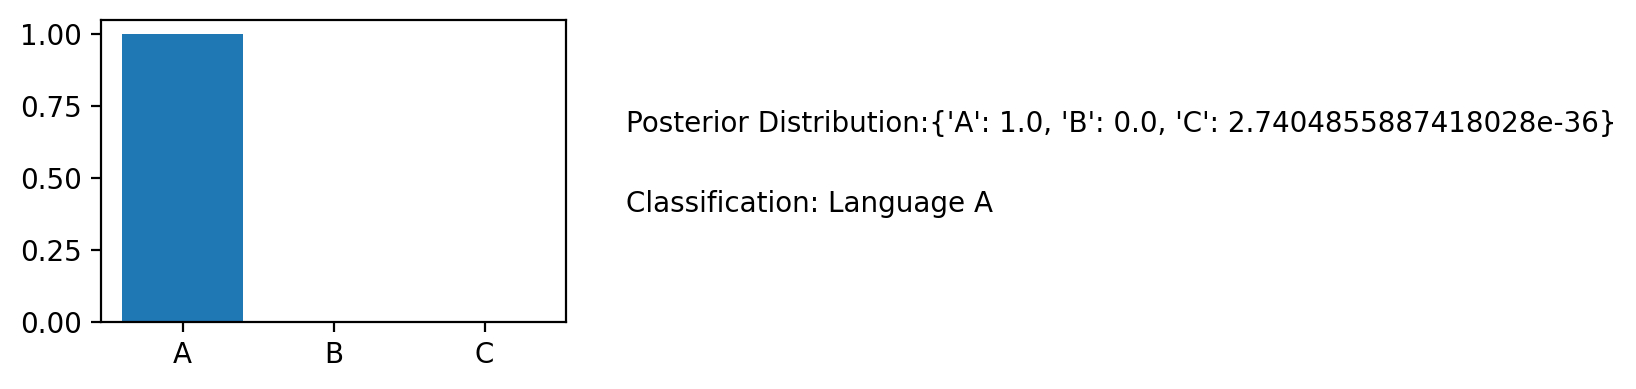

Sequence: ekogoAgkepokogoppAttpAttgeekApegepApotpAAtpetgAtpopAttpAppAtkokettkgAttggokoogApppepogeApopogetpokog
------------------------


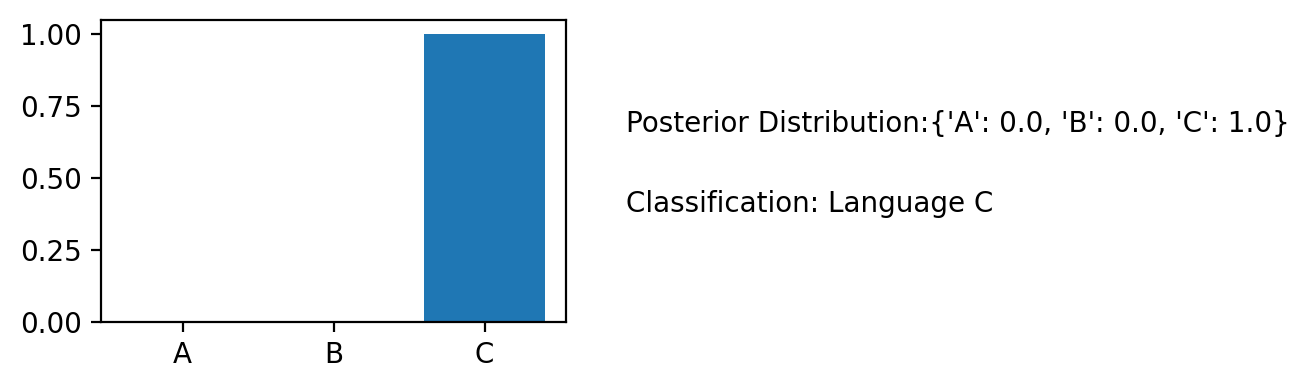

Sequence: tgAkoggAggAtpetkpAgegAgkepepookepepekogokogetkekekekegegotgekAAkoAtpottktkApAgtpegAkAgAkpopettgApogA
------------------------


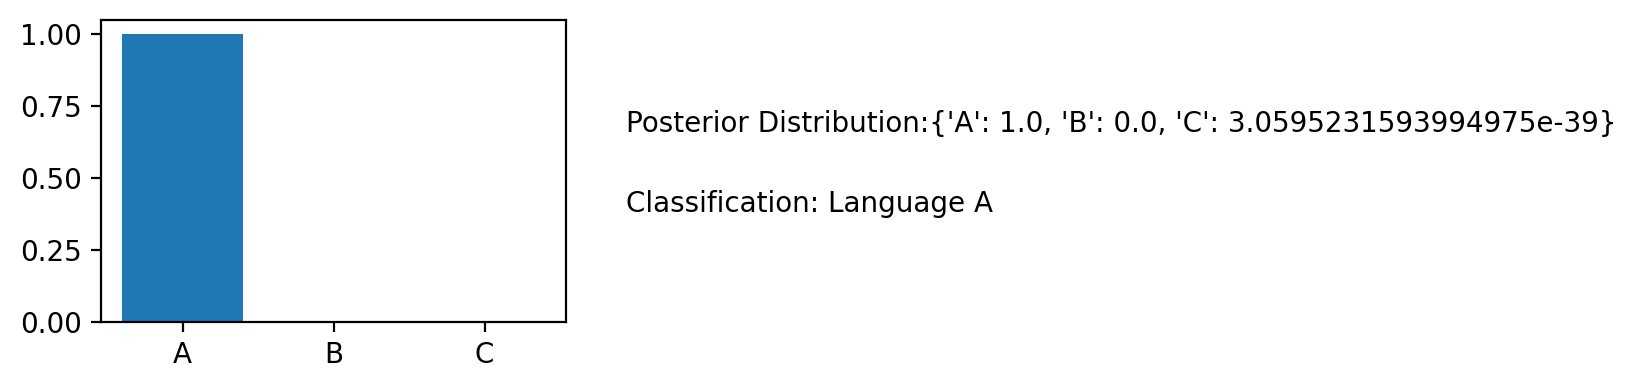

Sequence: pppooootgAookggggtttopAtttkkkeeggeeeeAAAgtkoAkkkkkooppppttppppppgppteoooooottkttttkkkktAAApgookkkkkp
------------------------


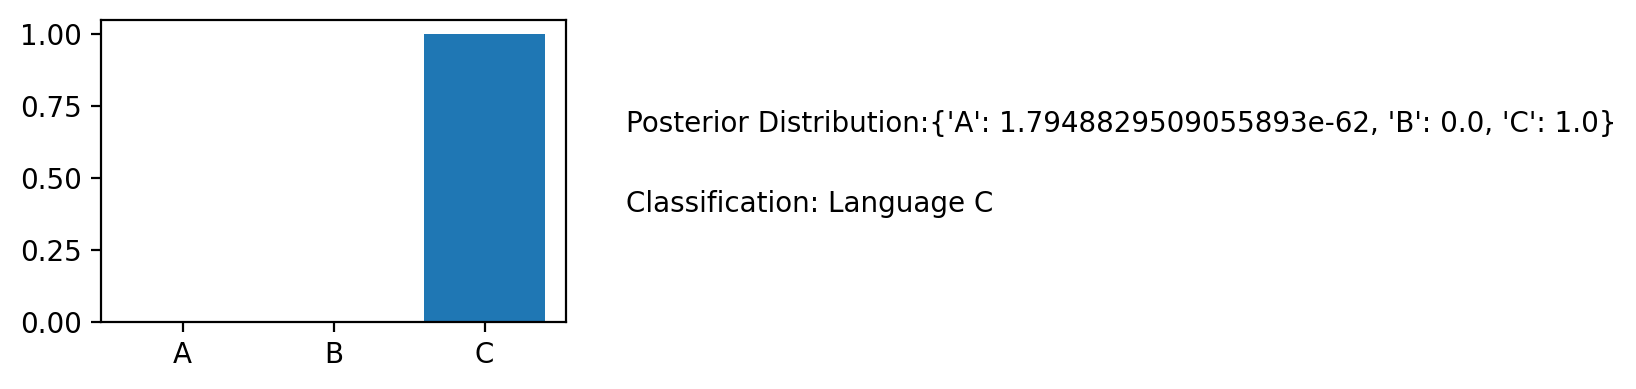

Sequence: ApgotgAApogotgopAgegAtkAgketgAtkpAgottpopopAgpekepokpAokettttpogotpegApAgopetgAgeketkotpokokApopegAt
------------------------


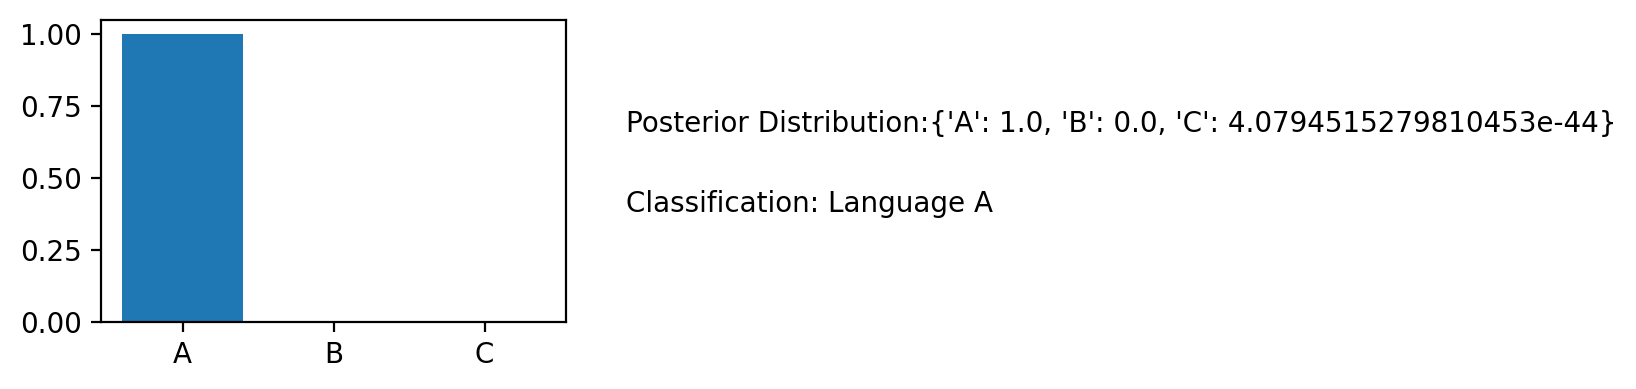

Sequence: oeeoppppppoooAgggggoAAoookkppeoAApeoAkAAAAAAApkpppgpppkkkkAAAAkkkkeeepeeeeeekktppppkeegggoooooooooAA
------------------------


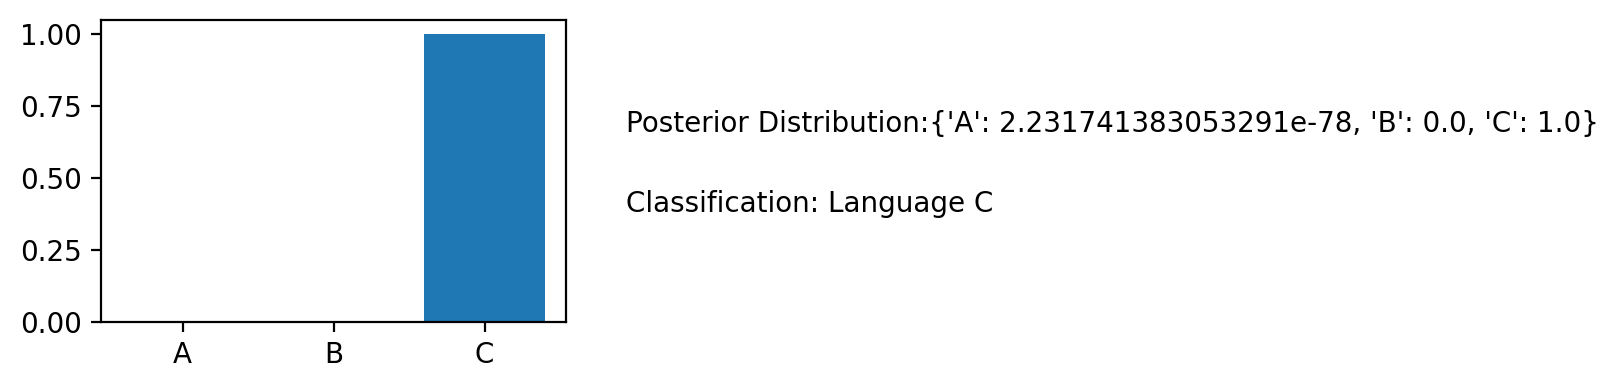

Sequence: gooooAAAAAAAAAkkkkkkooooAAAeppppppgeeeeepAAppeektetttgggogptttttttkppAAAApetAeegggtttteetttttppAAAAA
------------------------


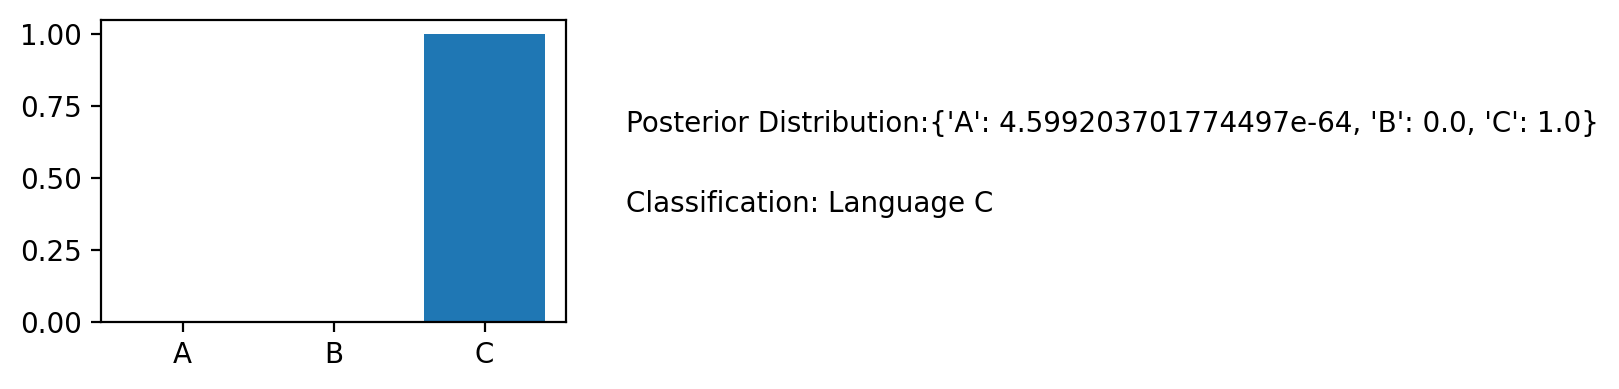

Sequence: kteoeoeoAoteoAgeoetoegAgeoekgeteoegetetAgeAoAttAtAteoAtetotAoAoeooegegAoetgeoAtegtAteteoAtAgegAgeAoA
------------------------


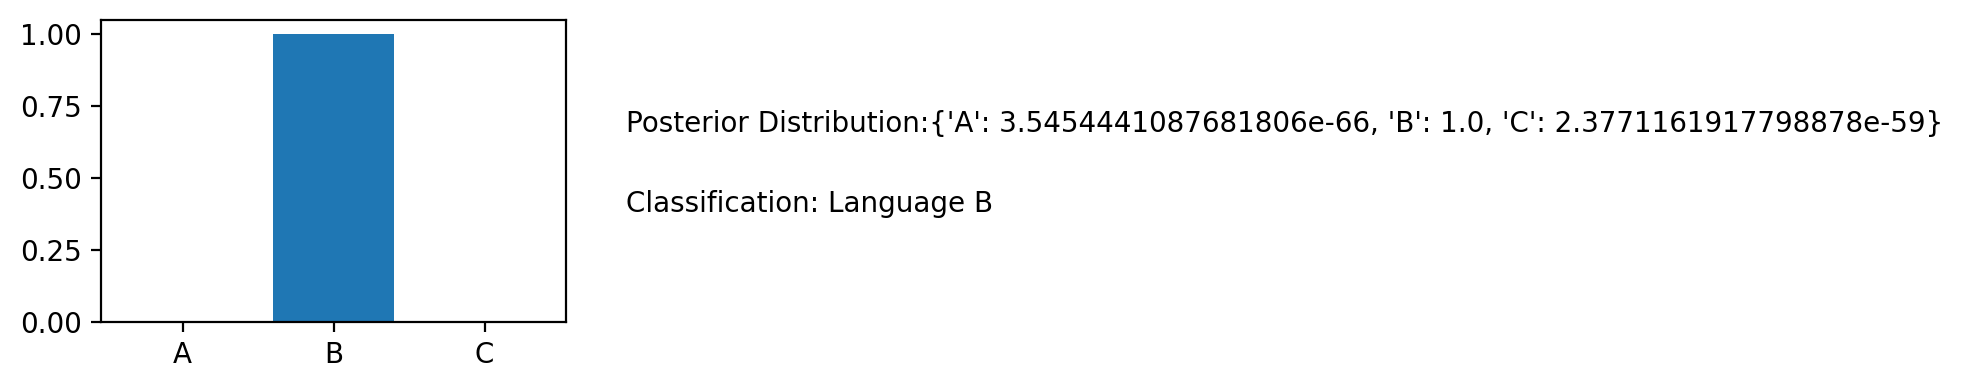

In [5]:
import matplotlib.pyplot as plt
classify_test_cases()

From the above, we see very high confidence in the classification after applying Baye's rule with our Markov model. This might suggest a the generation process is very simple to learn.

---

## 2. Speaker Identification
There are three people in a room. Each says about 10 phonemes before being randomly interrupted by someone else. When they speak they all sound the same, however each person tends to use different phonemes in their speech. Specifically, we can model the following transition probabilities that someone will interrupt the current speaker: P(speaker i at time t+1 | speaker j at time t). We can also model the probability over phonemes given a particular speaker: P(phoneme | speaker i). The phonemes are identical to the ones introduced in session 13.1 (but the transition matrices are obviously different, since they take a different form altogether).

- Write down the update equations that you will need to train a hidden Markov model. Using the information given above, write down a sensible initialization for the transition matrix.
- Write your own Python code to train a hidden Markov model on the data. You may look at code online, but will need to reference any code that helps you with your implementation.
- From matplotlib use a stackplot to show the probability of a particular person speaking.

### a. Import packages/libraries

In [129]:
import numpy as np
import seaborn as sns
from hmmlearn import hmm
from collections import Counter
import matplotlib.pyplot as plt

### b. Write down the update equation(s) needed to train a HMM

The update equation (induction step) is thus: 

$$ \alpha_j(t+1) = \sum_{i=1}^{N}{ \alpha_i(t)\alpha[x_i,x_j]b[x_j,o_{t+1}] }$$

where 

- $a_i(t)$ = predicted probability at time t-1
- $a[x_i, x_j]$ = transition probabilities, 3x3 matrix from speaker to speaker at t to t+1
- $b[x_k | o_{t+1}]$ = hidden speaker given observed data, or probability each speaker says that phoneme. Here, we're assuming each speaker says each phoneme with some probability unrelated to the phoneme spoken before.


### c. Initialization for the transition matrix

Given each speaker says roughly 10 words before being interrupted, I assume that the probability of the same speaker speaking in the next step is 0.9 and conversely the probability of being interrupted is 0.1 (split evenly between the two other speakers). Hence the transition matrix is thus:

$\begin{bmatrix}
0.9 & 0.05 & 0.05 \\
0.05 & 0.9 & 0.05 \\
0.05 & 0.05 & 0.9 \\
\end{bmatrix}$

### d. Train a hidden Markov model on the data

In [75]:
with open('speaker.txt') as f:
    recording = f.read()
    
#Display unique phonemes
phonemes = list(set(recording))

print(f"{len(phonemes)} phonemes: {phonemes}")

7 phonemes: ['o', 'e', 'g', 'p', 'k', 't', 'A']


#### (i) Initialize transition matrix
I use the initialization outlined above

In [77]:
#Initialize the transition matrix
t = np.full((3, 3), 0.05)

for i in range(0,3):
    t[i][i] = 0.9 
    
t

array([[0.9 , 0.05, 0.05],
       [0.05, 0.9 , 0.05],
       [0.05, 0.05, 0.9 ]])

#### (ii) Initialize emission matrix
We need 3 rows to indicate each speaker and 7 columns to indicate each phoneme. The emission matrix then gives us the probability of each phonemen given each (hidden) speaker

In [104]:
#Initialize a random emission matrix
e = np.random.dirichlet(np.ones(7),size=3) #the rows needs to sum to 1

#Check that each row sums up to 1
for row in range(len(e)):
    print(round(e[row].sum()))
    
e

1
1
1


array([[0.08373267, 0.07298544, 0.10543441, 0.20470568, 0.06911933,
        0.24557633, 0.21844613],
       [0.28443688, 0.05665296, 0.10157773, 0.38463994, 0.07382797,
        0.01685489, 0.08200962],
       [0.00248359, 0.28768515, 0.1805518 , 0.09899891, 0.26899158,
        0.11761059, 0.04367837]])

#### (iii) Initial distribution

In [105]:
#Initial probablities - generated arbitrarily
a = np.array([0.2,0.3,0.5])

The subsequent implementation of the hidden markov model heavily utilized the [hmmlearn](https://hmmlearn.readthedocs.io/en/latest/) package

#### (iv) Getting all the transitions and mapping the sequence to a integers

In [115]:
#Get all the transitions from the first letter
transitions = list(zip(recording, recording[1:]))

#Map phonemes to integers
mapping = {letter: index for (index, letter) in enumerate(phonemes)}
mapped_data = [mapping[v] for v in recording]
mapped_data = np.asarray(mapped_data).reshape(-1,1) #Reshape to fit hmmlearn requirements

#### (v) Fit the HMM model using HMMLearn

In [120]:
#We use multinomialHMM because our emissions are discrete
model = hmm.MultinomialHMM(n_components=3, n_iter=200, random_state= 123, verbose= True)

model.startprob_ = a
model.transmat_ = t
model.emissionprob_ = e

model.fit(mapped_data)

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
         1       -2001.1725             +nan
         2       -1876.1072        +125.0653
         3       -1875.4162          +0.6910
         4       -1874.6683          +0.7478
         5       -1873.7673          +0.9010
         6       -1872.5887          +1.1786
         7       -1870.9427          +1.6460
         8       -1868.5088          +2.4339
         9       -1864.7128          +3.7960
        10       -1858.4988          +6.2140
        11       -1847.9839         +10.5149
        12       -1830.3858         +17.5981
        13       -1803.9806         +26.4051
        14       -1773.6451         +30.3355
        15       -1749.9449         +23.7002
        16       -1734.7677         +15.1772
        17       -1720.0700

MultinomialHMM(n_components=3, n_iter=200,
               random_state=RandomState(MT19937) at 0x7F86137F98D0,
               verbose=True)

#### (vi) Predict the data using the fitted the HMM model

In [127]:
speaker = model.predict(mapped_data)
print(speaker)
Counter(speaker)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 2
 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1
 1 0 0 0 0 0 0 0 2 2 2 2 2 2 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
 1 1 1 1 1 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 0 0 0 0 0 0 2 2 2 2 2 2
 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0
 0 0 0 0 1 1 1 1 1 1 1 1 

Counter({1: 300, 0: 387, 2: 313})

#### (vii) Observe changes in the transition and emission matrices

In [123]:
print('Initial distribution')
print(model.startprob_, '\n')

print('Transition matrix')
print(model.transmat_, '\n')

print('Emission matrix')
print(model.emissionprob_)

Initial distribution
[5.60605112e-39 1.00000000e+00 4.35284106e-34] 

Transition matrix
[[0.90385241 0.05492338 0.04122421]
 [0.073099   0.85443369 0.07246731]
 [0.04198951 0.07057618 0.8874343 ]] 

Emission matrix
[[0.40977095 0.03656278 0.03246247 0.38394672 0.02510433 0.03884904
  0.07330371]
 [0.0722659  0.39670219 0.33145833 0.0595909  0.05169724 0.03336594
  0.05491948]
 [0.0483835  0.02099958 0.025099   0.02505916 0.04272064 0.43582547
  0.40191264]]


#### (viii) Return posterior probability of the data based on the model
*As always, rows sum up to 1*

In [125]:
probs = model.predict_proba(mapped_data)
print(probs)
np.array(probs.T).shape

[[2.47867734e-40 1.00000000e+00 3.65940543e-36]
 [3.35729192e-02 9.61518642e-01 4.90843883e-03]
 [4.07005354e-03 9.94838539e-01 1.09140751e-03]
 ...
 [8.61061680e-01 1.31614351e-01 7.32396929e-03]
 [9.53705057e-01 4.35056775e-02 2.78926504e-03]
 [9.53015383e-01 3.84921643e-02 8.49245249e-03]]


(3, 1000)

### d. Plot probability of a particular person speaking

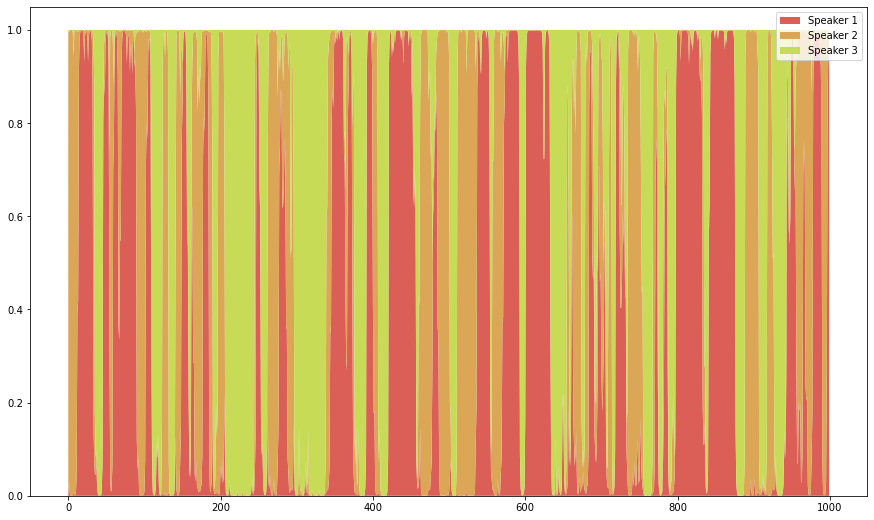

In [138]:
plt.figure(figsize=(15,9))
col_pallete = sns.color_palette("hls", 11)
plt.stackplot([*range(0,1000)],np.array(probs.T), 
              labels = [f"Speaker {i}" for i in range(1,4)],
              colors = col_pallete)
plt.legend()
plt.show()

Looks like there were quite some spells of Speaker 3 talking without interruption earlier on. Around the middle, Speaker 1 enjoyed such spells more. Towards the end, it was a bit of Speaker 1, but talking was a lot more varied between the speakers.